#Price Prediction of Amazon stock (AMZN) using Recurrent Neural Netwrok and LSTM





In [153]:
#importing necessary libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam




In [154]:
#loading the data saved in google drive also available on https://au.finance.yahoo.com/quote/AMZN/history
#data is stored in a google drive in a folder Assignment3 under the same google account

from google.colab import drive
drive.mount('/content/drive/')
amzn_price_data = pd.read_csv('/content/drive/MyDrive/Assignment3/AMZN-USD_nov08-nov22.csv')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [155]:
amzn_price_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-11-20,1.764500,1.986000,1.734000,1.751500,1.751500,368478000
1,2008-11-21,1.819500,1.950000,1.786000,1.893500,1.893500,300854000
2,2008-11-24,1.939500,2.172000,1.935000,2.125000,2.125000,290994000
3,2008-11-25,2.104500,2.144500,1.980500,2.109500,2.109500,260300000
4,2008-11-26,2.043500,2.200000,2.014500,2.198000,2.198000,268794000
...,...,...,...,...,...,...,...
3519,2022-11-14,98.769997,100.120003,97.290001,98.489998,98.489998,99533100
3520,2022-11-15,103.209999,103.790001,97.339996,98.940002,98.940002,111336300
3521,2022-11-16,96.849998,98.489998,95.540001,97.120003,97.120003,87958800
3522,2022-11-17,95.370003,96.970001,94.029999,94.849998,94.849998,82617900


In [156]:
#extracting only the required data for the model
amzn_price_data = amzn_price_data[['Date','Close']]
amzn_price_data

,Date,Close
0,2008-11-20,1.751500
1,2008-11-21,1.893500
2,2008-11-24,2.125000
3,2008-11-25,2.109500
4,2008-11-26,2.198000
...,...,...
3519,2022-11-14,98.489998
3520,2022-11-15,98.940002
3521,2022-11-16,97.120003
3522,2022-11-17,94.849998


In [157]:
#converting date to datetime format using datetime library

def obj_to_datetime(obj):
  new_obj = obj.split('-')
  return datetime.datetime(year=int(new_obj[0]), month=int(new_obj[1]), day=int(new_obj[2]))

obj_to_datetime(amzn_price_data['Date'][0])

datetime.datetime(2008, 11, 20, 0, 0)

In [158]:
#applying the datetime conversion function to the data frame

amzn_price_data['Date'] = amzn_price_data['Date'].apply(obj_to_datetime)
# type(amzn_price_data['Date'][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [159]:
#reformatting the data frame to have timestamps as index values and closing value as the only column

amzn_price_data.index = amzn_price_data.pop('Date')
amzn_price_data

,Close
Date,
2008-11-20,1.751500
2008-11-21,1.893500
2008-11-24,2.125000
2008-11-25,2.109500
2008-11-26,2.198000
...,...
2022-11-14,98.489998
2022-11-15,98.940002
2022-11-16,97.120003


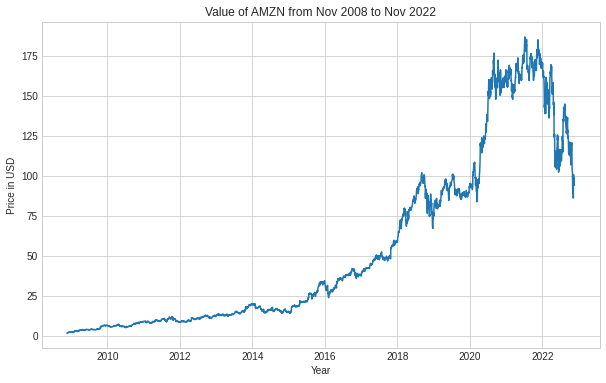

In [160]:
#plotting the data we have...

# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
plt.title('Value of AMZN from Nov 2008 to Nov 2022')
plt.xlabel('Year')
plt.ylabel('Price in USD')
plt.plot(amzn_price_data)


In [161]:
#normalizing the data using min-max normalization for easier calculations

# amzn_price_data=(amzn_price_data-amzn_price_data.min())/(amzn_price_data.max()-amzn_price_data.min())


In [162]:

def modified_df(df, start_date, end_date, n):

    first_date = obj_to_datetime(start_date)
    last_date  = obj_to_datetime(end_date)

    target_date = first_date

    dates, X, Y = list(), list(), list()

    last_time = False
    while True:

        df_subset = df.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print('error, change \'n\' or start date')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(n):
        X[:, i]
        ret_df[f't - {n-i} days'] = X[:, i]

    ret_df['Target(t)'] = Y

    return ret_df


data_frame = modified_df(amzn_price_data,'2018-11-26', '2022-10-19', n=4)
data_frame

,Target Date,t - 4 days,t - 3 days,t - 2 days,t - 1 days,Target(t)
0,2018-11-26,75.614502,74.773003,75.836502,75.102997,79.066498
1,2018-11-27,74.773003,75.836502,75.102997,79.066498,79.070999
2,2018-11-28,75.836502,75.102997,79.066498,79.070999,83.887497
3,2018-11-29,75.102997,79.066498,79.070999,83.887497,83.678497
4,2018-11-30,79.066498,79.070999,83.887497,83.678497,84.508499
...,...,...,...,...,...,...
977,2022-10-13,114.559998,113.669998,112.209999,112.900002,112.529999
978,2022-10-14,113.669998,112.209999,112.900002,112.529999,106.900002
979,2022-10-17,112.209999,112.900002,112.529999,106.900002,113.790001
980,2022-10-18,112.900002,112.529999,106.900002,113.790001,116.360001


In [163]:

def data_frame_to_input_data(data_frame):
    
    df_to_np = data_frame.to_numpy()
    dates = df_to_np[:,0]

    temp_df = df_to_np[:,1:-1]
    X = temp_df.reshape((len(dates), temp_df.shape[1], 1))
    y = df_to_np[:,-1]

    return dates, X.astype(np.float32), y.astype(np.float32)

In [164]:
dates, X, y = data_frame_to_input_data(data_frame)

dates.shape, X.shape, y.shape

((982,), (982, 4, 1), (982,))

In [165]:
#train, test, validation split

index1 = int(len(dates) * 0.8)
index2 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:index1], X[:index1], y[:index1]
dates_val, X_val, y_val = dates[index1:index2], X[index1:index2], y[index1:index2]
dates_test, X_test, y_test = dates[index2:], X[index2:], y[index2:]


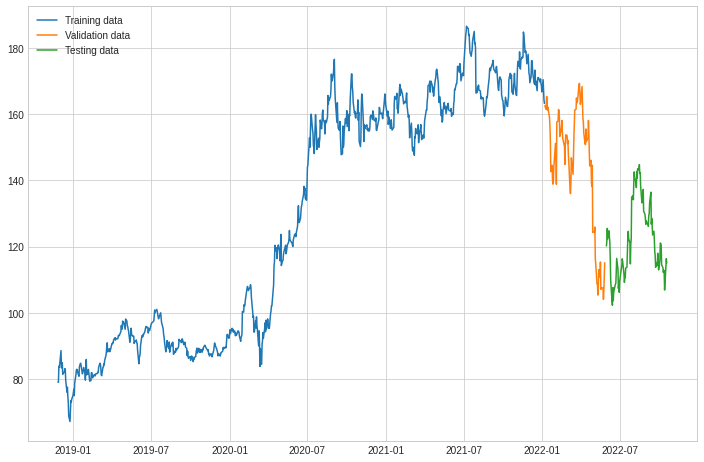

In [166]:
plt.figure(figsize=(12,8))
plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)
plt.legend(['Training data','Validation data','Testing data'],loc='upper left')

In [167]:
# model = Sequential([layers.Input((X.shape[1],1)),
#                    layers.LSTM(128),
#                    layers.Dense(64, activation='relu'),
#                    layers.Dense(32, activation='relu'),
#                    layers.Dense(1)])

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1],1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])


In [168]:
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 100)

Epoch 1/100
25/25 [==============================] - 6s 61ms/step - loss: 17785.9648 - mean_absolute_error: 128.2700 - val_loss: 20768.5859 - val_mean_absolute_error: 142.8989
Epoch 2/100
25/25 [==============================] - 1s 25ms/step - loss: 16679.4570 - mean_absolute_error: 123.8950 - val_loss: 18616.0234 - val_mean_absolute_error: 135.1560
Epoch 3/100
25/25 [==============================] - 1s 25ms/step - loss: 14373.7314 - mean_absolute_error: 114.1281 - val_loss: 15590.9297 - val_mean_absolute_error: 123.4603
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 11297.4766 - mean_absolute_error: 99.7817 - val_loss: 11448.3467 - val_mean_absolute_error: 105.3566
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 7279.5479 - mean_absolute_error: 76.8340 - val_loss: 6273.4043 - val_mean_absolute_error: 76.9745
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 3484.1677 - mean_absolute_error: 47.2641 - val_loss

25/25 [==============================] - 1s 4ms/step


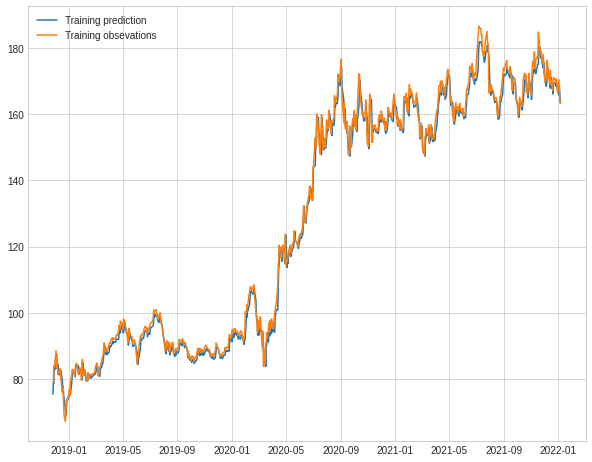

In [169]:

train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(10,8))
plt.plot(dates_train,train_predictions)
plt.plot(dates_train,y_train)
plt.legend(['Training prediction','Training obsevations'])


In [170]:
# model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 4, 64)             16896     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 53,089
Trainable params: 53,089
Non-trainable params: 0
_________________________________________________________________


4/4 [==============================] - 0s 5ms/step


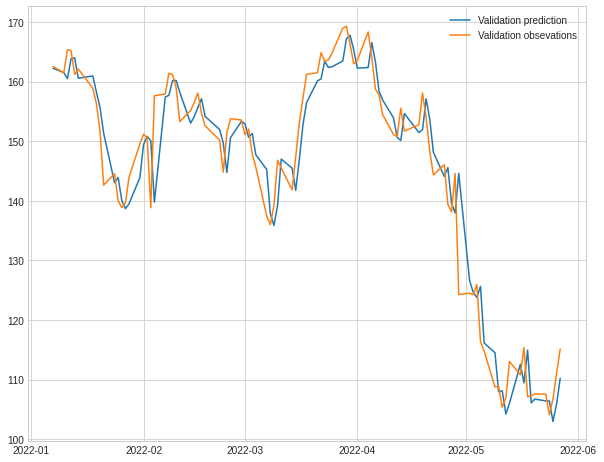

In [171]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(10,8))
plt.plot(dates_val,val_predictions)
plt.plot(dates_val,y_val)
plt.legend(['Validation prediction','Validation obsevations'])


4/4 [==============================] - 0s 5ms/step


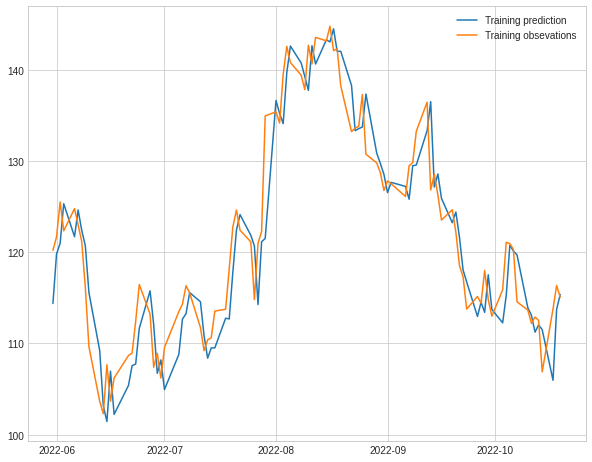

In [172]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(10,8))
plt.plot(dates_test,test_predictions)
plt.plot(dates_test,y_test)
plt.legend(['Training prediction','Training obsevations'])


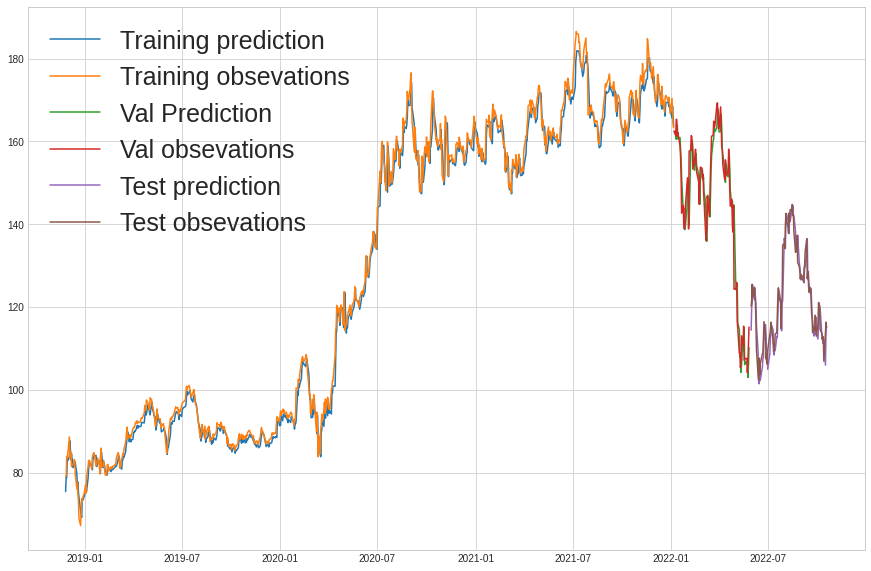

In [173]:

plt.figure(figsize=(15,10))
plt.plot(dates_train,train_predictions)
plt.plot(dates_train,y_train)
plt.plot(dates_val,val_predictions)
plt.plot(dates_val,y_val)
plt.plot(dates_test,test_predictions)
plt.plot(dates_test,y_test)
plt.legend(['Training prediction','Training obsevations','Val Prediction','Val obsevations','Test prediction','Test obsevations'],prop={'size':25})